# Universal Differential Equations in NeuroMANCER  


This tutorial demonstrates the use of [Universal Differential Equations](https://arxiv.org/abs/2001.04385) (UDE) for gray-box system identificaiton of dynamical systems. 


## System Identification Problem Setup

<img src="../figs/NODE.PNG" width="600">  


Starting from a given initial condition  $x_{0}$, the next state of the system  $x_{k+1}$
is obtained by feeding the current state $x_{k}$ into the gray-box model $N$ that generates a derivative to be
integrated using an integration scheme $\int$. In system identification, the loss $\mathcal{L}$ is evaluated by comparing the  trajectory generated by the model with the training trajectory. The process can be repeated for multiple trajectories to improve the generalization of the model.


### References

[1] [Christopher Rackauckas, Yingbo Ma, Julius Martensen, Collin Warner, Kirill Zubov, Rohit Supekar, Dominic Skinner, Ali Ramadhan, Alan Edelman, Universal Differential Equations for Scientific Machine Learning, arXiv:2001.04385](https://arxiv.org/abs/2001.04385)  
[2] https://github.com/ChrisRackauckas/universal_differential_equations  
[3] https://www.youtube.com/watch?v=bBH8HVEr0-A&ab_channel=ChristopherRackauckas  
[4] [Christian Legaard, Thomas Schranz, Gerald Schweiger, Ján Drgoňa, Basak Falay, Cláudio Gomes, Alexandros Iosifidis, Mahdi Abkar, and Peter Larsen. 2023. Constructing Neural Network Based Models for Simulating Dynamical Systems. ACM Comput. Surv. 55, 11, Article 236 (November 2023), 34 pages.](https://dl.acm.org/doi/10.1145/3567591)



## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

In [6]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.psl import plot
from neuromancer import psl

torch.manual_seed(0)

## Generate trajectories from ODE system 

Consider the [Brusselator system](https://en.wikipedia.org/wiki/Brusselator) defined by the following [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation): 

$$
 \frac{dx_1}{dt} = \alpha + x_2 x_1^2 -\beta x_1 -x_1  \\  
 \frac{dx_2}{dt} = \beta x_1 - x_2 x_1^2
$$  

In this example we assume a partial prior knowledge on the system dynamics plus access to limited measurements of the system states $x$.

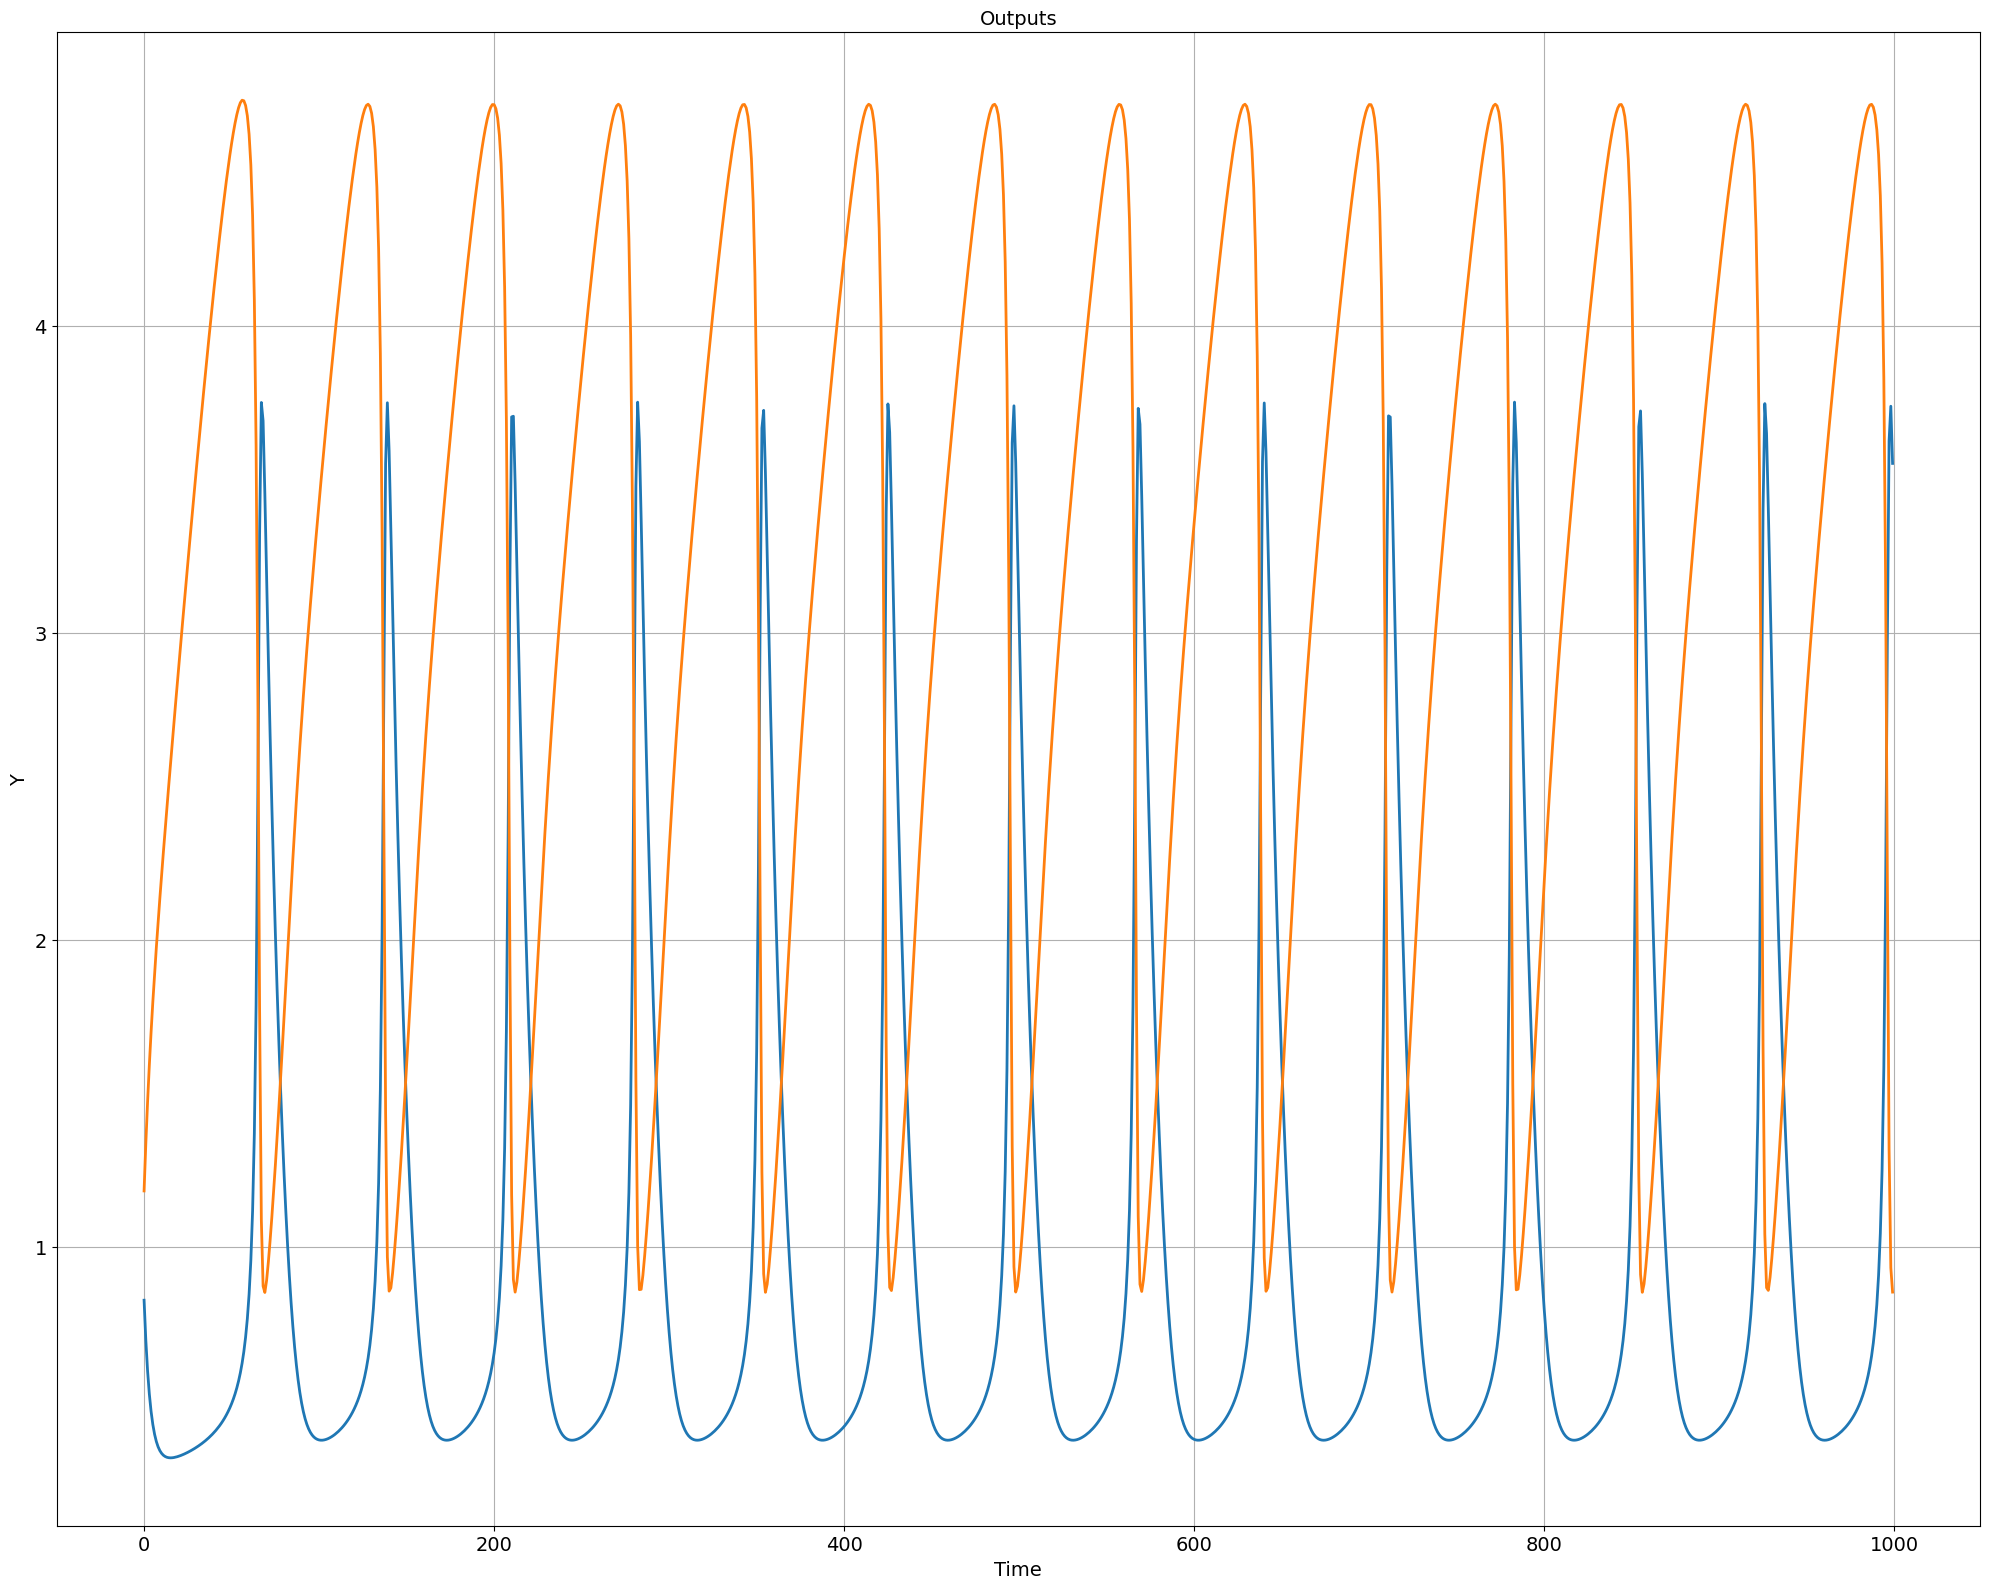

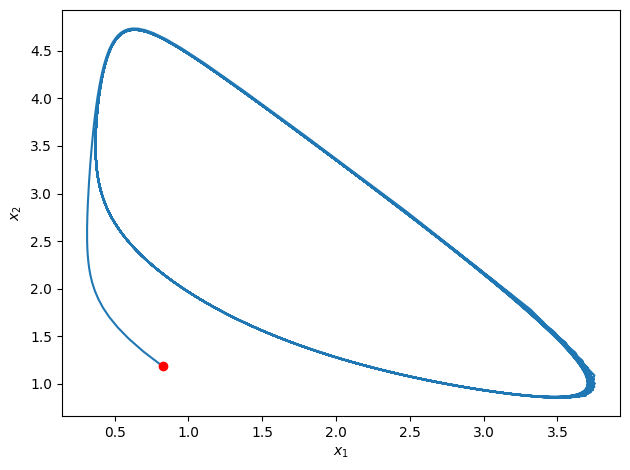

In [7]:
system = psl.systems['Brusselator1D']
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
raw = modelSystem.simulate(nsim=1000, ts=ts)
plot.pltOL(Y=raw['Y'])
plot.pltPhase(X=raw['Y'])

## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics to model: 
$$\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.


In [8]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :]}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :]}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = test_sim['X'][:length].reshape(1, nsim, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    test_data = {'X': testX, 'xn': testX[:, 0:1, :]}

    return train_loader, dev_loader, test_data

In [9]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = 2   # number of prediction horizon steps in the loss function
bs = 100     # minibatching batch size
train_loader, dev_loader, test_data = get_data(modelSystem, nsim, nsteps, ts, bs)

## UDE system model in Neuromancer

Here we construct a continuous-time UDE model of partially known Brusselator system:

$$
 \frac{dx_1}{dt} = \alpha + g_{\theta}(x_1, x_2) -\beta x_1 -x_1  \\  
 \frac{dx_2}{dt} = \beta x_1 - g_{\theta}(x_1, x_2)
$$  

with unkwnown physical parameters $\alpha$, $\beta$, and parameters $\theta$ of a neural network $g_{\theta}$ approximation of unknown physical terms. Thus we can compactly represent the system as $\dot{x} = f_{\theta,\alpha,\beta}(x)$.

In [10]:
# define UDE system in Neuromancer
class BrusselatorHybrid(ode.ODESystem):
    def __init__(self, block, insize=2, outsize=2):
        """

        :param block:
        :param insize:
        :param outsize:
        """
        super().__init__(insize=insize, outsize=outsize)
        self.block = block
        self.alpha = torch.nn.Parameter(torch.tensor([5.0], requires_grad=True))
        self.beta = torch.nn.Parameter(torch.tensor([5.0], requires_grad=True))
        assert self.block.in_features == 2
        assert self.block.out_features == 1

    def ode_equations(self, x):
        x1 = x[:, [0]]
        x2 = x[:, [-1]]
        dx1 = self.alpha + self.block(x) - self.beta*x1 - x1
        dx2 = self.beta*x1 -self.block(x)
        return torch.cat([dx1, dx2], dim=-1)

In [11]:
# instantiate the UDE model in Neuromancer
net = blocks.MLP(2, 1, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.GELU,
                 hsizes=4*[20])
fx = BrusselatorHybrid(net)

Next we need to solve the continuous-time UDE model with suitable ODE solver, e.g., [Runge–Kutta integrator](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods).  
$x_{k+1} = \text{ODESolve}(f_{\theta,\alpha,\beta}(x))$ 

For training we need to obtain accurate reverse-mode gradients of the integrated NODE system. This can be done in two ways, either by unrolling the operations of the ODE solver and using the [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time) (BPTT) algorithm, or via [Adjoint state method](https://en.wikipedia.org/wiki/Adjoint_state_method).
Neuromancer provides a set of ODE solvers implemented in [integrators.py](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/dynamics/integrators.py).
For adjoint method we provide the interface to the [open-source implementation](https://github.com/rtqichen/torchdiffeq) via DiffEqIntegrator class.  In this example we will use BPTT algorithm through unrolled RK4 solver.

In [12]:
# integrate UDE model
fxRK4 = integrators.RK4(fx, h=ts)

Next we construct an open-loop system composed of a smbolic NODE model

In [13]:
# create symbolic UDE model
ude = Node(fxRK4, ['xn'], ['xn'], name='UDE')
dynamics_model = System([ude], nsteps=nsteps)

In [14]:
# visualize the system
# dynamics_model.show()

## Define system identification loss function terms

Here we define loss function terms to fit the UDE parameters from given time-series data.

**Tracking loss:**  
$$\ell_x = Q_x||x^i_k - \hat{x}^i_k||_2^2$$ 

**One-step loss:**  
$$\ell_x = Q_x||x^i_1 - \hat{x}^i_1||_2^2$$ 

**Finite difference loss:**  
$$\ell_{dx} =  Q_{dx}||\Delta x^i_k - \Delta \hat{x}^i_k||_2^2$$
where $\Delta x^i_k = x^i_{k+1} - x^i_k$

In [15]:
# %% Constraints + losses:
x = variable("X")
xhat = variable('xn')[:, :-1, :]

# trajectory tracking loss
reference_loss = 1.*(xhat == x)^2
reference_loss.name = "ref_loss"

# one-step tracking loss
onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# finite difference variables
xFD = (x[:, 1:, :] - x[:, :-1, :])
xhatFD = (xhat[:, 1:, :] - xhat[:, :-1, :])

# finite difference loss
fd_loss = 2.0*((xFD == xhatFD)^2)
fd_loss.name = 'FD_loss'

## Construct System ID learning problem

Given the training dataset $\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}]$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta,\alpha,\beta}{\text{minimize}}     && \sum_{i=1}^m \Big(Q_x||x^i_1 - \hat{x}^i_1||_2^2  + \sum_{k=1}^{N}  Q_x||x^i_k - \hat{x}^i_k||_2^2  +  \sum_{k=1}^{N-1}  Q_{dx}||\Delta x^i_k - \Delta \hat{x}^i_k||_2^2  \Big) \\
&\text{subject to}    && x^i_{k+1} =  \text{ODESolve}(f_{\theta,\alpha,\beta}(x^i_k)) \\
\end{align}
$$  

In [16]:
# aggregate list of objective terms and constraints
objectives = [reference_loss, fd_loss, onestep_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

In [17]:
# plot computational graph
# problem.show()

## Solve the problem

We fit the unknown NODE parameters $\theta,\alpha,\beta$ using stochastic gradient descent.

In [18]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.003)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=50,
    warmup=100,
    epochs=1000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)

In [19]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0  train_loss: 1.095097303390503
epoch: 1  train_loss: 1.0418245792388916
epoch: 2  train_loss: 0.942970871925354
epoch: 3  train_loss: 0.8509234189987183
epoch: 4  train_loss: 0.7784931659698486
epoch: 5  train_loss: 0.6271647214889526
epoch: 6  train_loss: 0.3906003534793854
epoch: 7  train_loss: 0.30727311968803406
epoch: 8  train_loss: 0.24316498637199402
epoch: 9  train_loss: 0.19335809350013733
epoch: 10  train_loss: 0.1614343225955963
epoch: 11  train_loss: 0.1415272355079651
epoch: 12  train_loss: 0.12982061505317688
epoch: 13  train_loss: 0.12252940237522125
epoch: 14  train_loss: 0.11783436685800552
epoch: 15  train_loss: 0.11291483789682388
epoch: 16  train_loss: 0.10874038934707642
epoch: 17  train_loss: 0.10481488704681396
epoch: 18  train_loss: 0.10146129131317139
epoch: 19  train_loss: 0.09852737933397293
epoch: 20  train_loss: 0.09597935527563095
epoch: 21  train_loss: 0.09365765750408173
epoch: 22  train_loss: 0.09155638515949249
epoch: 23  train_loss: 0.0896648

epoch: 188  train_loss: 0.0011535303201526403
epoch: 189  train_loss: 0.0010995694901794195
epoch: 190  train_loss: 0.0010455447481945157
epoch: 191  train_loss: 0.0010040767956525087
epoch: 192  train_loss: 0.0009690173901617527
epoch: 193  train_loss: 0.0009329415042884648
epoch: 194  train_loss: 0.0008847229182720184
epoch: 195  train_loss: 0.000850704382173717
epoch: 196  train_loss: 0.0008139124256558716
epoch: 197  train_loss: 0.0007817412842996418
epoch: 198  train_loss: 0.0007518120110034943
epoch: 199  train_loss: 0.0007146131829358637
epoch: 200  train_loss: 0.0006839103298261762
epoch: 201  train_loss: 0.000655899231787771
epoch: 202  train_loss: 0.0006280255620367825
epoch: 203  train_loss: 0.0006025029579177499
epoch: 204  train_loss: 0.0005780114443041384
epoch: 205  train_loss: 0.000553444551769644
epoch: 206  train_loss: 0.0005316414753906429
epoch: 207  train_loss: 0.0005077725509181619
epoch: 208  train_loss: 0.0004867039970122278
epoch: 209  train_loss: 0.00046647357

epoch: 365  train_loss: 1.6119487554533407e-05
epoch: 366  train_loss: 8.275539585156366e-06
epoch: 367  train_loss: 8.331394383276347e-06
epoch: 368  train_loss: 6.7249275161884725e-06
epoch: 369  train_loss: 1.2329839591984637e-05
epoch: 370  train_loss: 1.9645585780381225e-05
epoch: 371  train_loss: 1.1206166163901798e-05
epoch: 372  train_loss: 2.5251545594073832e-05
epoch: 373  train_loss: 0.0002197099820477888
epoch: 374  train_loss: 0.0002244639617856592
epoch: 375  train_loss: 0.0002966496685985476
epoch: 376  train_loss: 0.00013129800208844244
epoch: 377  train_loss: 0.0002727644459810108
epoch: 378  train_loss: 0.002543974667787552
epoch: 379  train_loss: 0.002118464792147279
epoch: 380  train_loss: 0.0018977995496243238
epoch: 381  train_loss: 0.0004815678112208843
epoch: 382  train_loss: 0.0003255789924878627
epoch: 383  train_loss: 0.00014316316810436547
epoch: 384  train_loss: 4.2345189285697415e-05
epoch: 385  train_loss: 2.4761722670518793e-05
epoch: 386  train_loss: 1.

<All keys matched successfully>

## Parameter estimation results

In [20]:
# evaluate learned parameters
print('Learned parameter a=', float(fx.alpha))
print('Learned parameter b=', float(fx.beta))

print('True parameter a=', float(modelSystem.a))
print('True parameter b=', float(modelSystem.b))

Learned parameter a= 1.001916766166687
Learned parameter b= 4.800117015838623
True parameter a= 1.0
True parameter b= 3.0


In [22]:
# update the rollout length based on the test data
dynamics_model.nsteps = test_data['X'].shape[1]

In [23]:
# Test set results
test_outputs = dynamics_model(test_data)

pred_traj = test_outputs['xn'][:, :-1, :]
true_traj = test_data['X']
pred_traj = pred_traj.detach().numpy().reshape(-1, nx)
true_traj = true_traj.detach().numpy().reshape(-1, nx)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

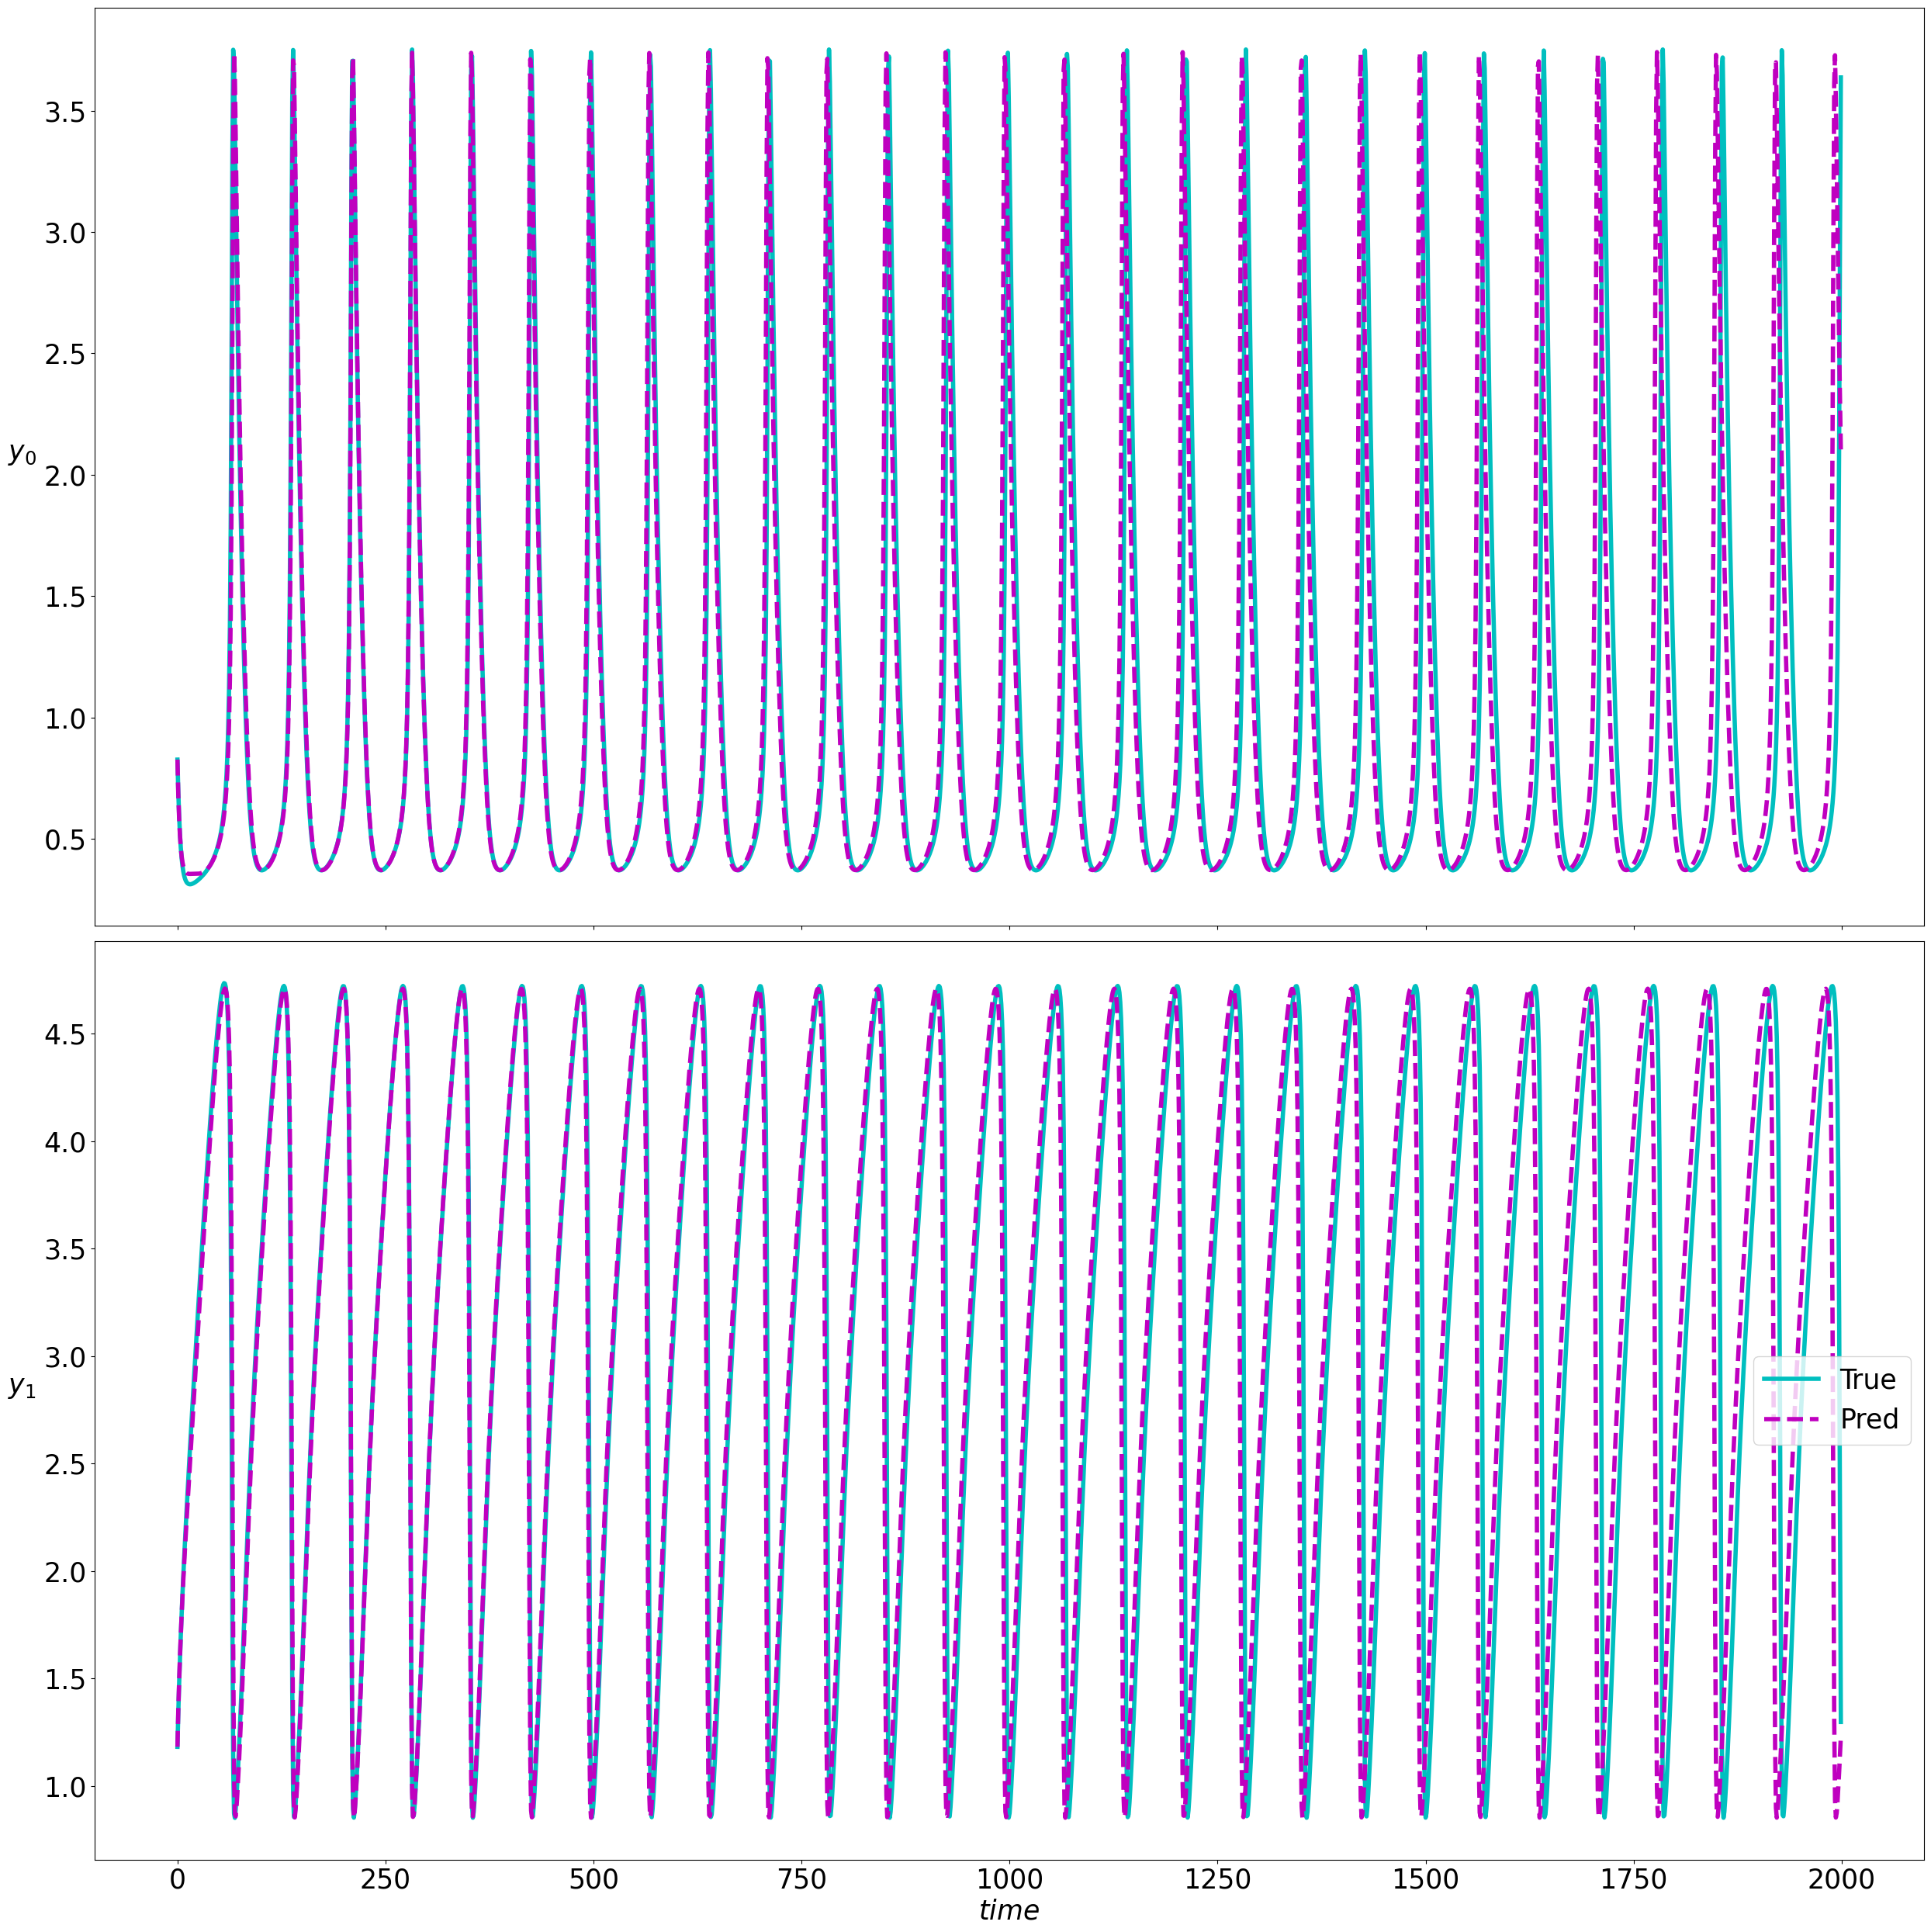

In [24]:
figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()